In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
OriginDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/OriginData'
TrainTestDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/TrainTestData'
ModelSaveDir = 'models'
ResultSaveDir = 'result'

In [2]:
def loadData(DataName):
    DataPath = os.path.join(TrainTestDataDir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    OriginData = pd.read_csv(DataPath, index_col=0)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData

In [3]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBOOST Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('XGBOOST_ImportantFeats.png')

In [4]:
TestData = loadData('AllTest_withnull.csv')
TestID = TestData.SK_ID_CURR.values
AllTrainData = loadData('AllTrain_withnull.csv')
AllTrainData.reset_index(drop=True, inplace=True)

In [5]:
AllTrainData.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,preapp_SK_ID_CURR_mean_CNT_PAYMENT,preapp_SK_ID_CURR_max_CNT_PAYMENT,preapp_SK_ID_CURR_sum_AMT_DOWN_PAYMENT,180_period_trend_days_credit_diff,360_period_trend_days_credit_diff,720_period_trend_days_credit_diff,bureau_SK_ID_CURR_max_DAYS_CREDIT_ENDDATE,bureau_SK_ID_CURR_max_DAYS_CREDIT,bureau_SK_ID_CURR_var_AMT_CREDIT_SUM_LIMIT,TARGET
0,100002,1,0.0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,24.000000,24.0,0.00,0.0,0.0,-84.5,780.0,-103.0,2.558171e+08,1
1,100003,1,1.0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,10.000000,12.0,6885.00,NaN,NaN,0.0,1216.0,-606.0,1.640250e+11,0
2,100004,0,0.0,1,1,0,67500.0,135000.0,6750.0,135000.0,...,4.000000,4.0,4860.00,NaN,NaN,0.0,-382.0,-408.0,0.000000e+00,0
3,100006,1,1.0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,23.000000,48.0,69680.34,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,1,0.0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,20.666667,48.0,6781.50,NaN,NaN,NaN,-783.0,-1149.0,NaN,0


In [6]:
applicationTrainPath = os.path.join(OriginDataDir,'application_train.csv')
application = pd.read_csv(applicationTrainPath)
applicationTestPath = os.path.join(OriginDataDir,'application_test.csv')
application_test = pd.read_csv(applicationTestPath)
application = application.append(application_test)
application.head()

/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
application.shape

(356255, 122)

In [8]:
categoryFeats = CATEGORICAL_COLUMNS = ['CODE_GENDER',
                       'EMERGENCYSTATE_MODE',
                       'FLAG_DOCUMENT_3',
                       'FLAG_DOCUMENT_4',
                       'FLAG_DOCUMENT_5',
                       'FLAG_DOCUMENT_6',
                       'FLAG_DOCUMENT_7',
                       'FLAG_DOCUMENT_8',
                       'FLAG_DOCUMENT_9',
                       'FLAG_DOCUMENT_11',
                       'FLAG_DOCUMENT_18',
                       'FLAG_EMAIL',
                       'FLAG_EMP_PHONE',
                       'FLAG_MOBIL',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'FLAG_PHONE',
                       'FLAG_WORK_PHONE',
                       'FONDKAPREMONT_MODE',
                       'HOUR_APPR_PROCESS_START',
                       'HOUSETYPE_MODE',
                       'LIVE_CITY_NOT_WORK_CITY',
                       'LIVE_REGION_NOT_WORK_REGION',
                       'NAME_CONTRACT_TYPE',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'ORGANIZATION_TYPE',
                       'REG_CITY_NOT_LIVE_CITY',
                       'REG_CITY_NOT_WORK_CITY',
                       'REG_REGION_NOT_LIVE_REGION',
                       'REG_REGION_NOT_WORK_REGION',
                       'WALLSMATERIAL_MODE',
                       'WEEKDAY_APPR_PROCESS_START']

In [9]:
df_cat = application[['SK_ID_CURR']+categoryFeats]
for catname in categoryFeats:
    df_cat[catname] = LabelEncoder().fit_transform(df_cat[catname].astype(str))
    df_cat[catname] = df_cat[catname].astype('category')
df_cat.head()

/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,SK_ID_CURR,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,100002,1,0,1,0,0,0,0,0,0,...,3,1,8,5,0,0,0,0,5,6
1,100003,0,0,1,0,0,0,0,0,0,...,1,1,3,39,0,0,0,0,0,1
2,100004,1,2,0,0,0,0,0,0,0,...,3,1,8,11,0,0,0,0,7,1
3,100006,0,2,1,0,0,0,0,0,0,...,0,1,8,5,0,0,0,0,7,6
4,100007,1,2,0,0,0,0,0,1,0,...,3,1,3,37,0,1,0,0,7,4


In [10]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Data columns (total 38 columns):
SK_ID_CURR                     356255 non-null int64
CODE_GENDER                    356255 non-null category
EMERGENCYSTATE_MODE            356255 non-null category
FLAG_DOCUMENT_3                356255 non-null category
FLAG_DOCUMENT_4                356255 non-null category
FLAG_DOCUMENT_5                356255 non-null category
FLAG_DOCUMENT_6                356255 non-null category
FLAG_DOCUMENT_7                356255 non-null category
FLAG_DOCUMENT_8                356255 non-null category
FLAG_DOCUMENT_9                356255 non-null category
FLAG_DOCUMENT_11               356255 non-null category
FLAG_DOCUMENT_18               356255 non-null category
FLAG_EMAIL                     356255 non-null category
FLAG_EMP_PHONE                 356255 non-null category
FLAG_MOBIL                     356255 non-null category
FLAG_OWN_CAR                   356255 non-null catego

In [11]:
#把原来的onehot去掉
for s in categoryFeats:
    AllTrainData.drop(AllTrainData.filter(regex='%s*'%s).columns.tolist(),axis=1,inplace=True)
    TestData.drop(TestData.filter(regex='%s*'%s).columns.tolist(),axis=1,inplace=True)

In [12]:
AllTrainData.shape

(307511, 1062)

In [13]:
TestData.shape

(48744, 1061)

In [14]:
AllTrainData.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,preapp_SK_ID_CURR_mean_CNT_PAYMENT,preapp_SK_ID_CURR_max_CNT_PAYMENT,preapp_SK_ID_CURR_sum_AMT_DOWN_PAYMENT,180_period_trend_days_credit_diff,360_period_trend_days_credit_diff,720_period_trend_days_credit_diff,bureau_SK_ID_CURR_max_DAYS_CREDIT_ENDDATE,bureau_SK_ID_CURR_max_DAYS_CREDIT,bureau_SK_ID_CURR_var_AMT_CREDIT_SUM_LIMIT,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,24.000000,24.0,0.00,0.0,0.0,-84.5,780.0,-103.0,2.558171e+08,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,...,10.000000,12.0,6885.00,NaN,NaN,0.0,1216.0,-606.0,1.640250e+11,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,...,4.000000,4.0,4860.00,NaN,NaN,0.0,-382.0,-408.0,0.000000e+00,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,...,23.000000,48.0,69680.34,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,...,20.666667,48.0,6781.50,NaN,NaN,NaN,-783.0,-1149.0,NaN,0


In [15]:
#merge
AllTrainData = AllTrainData.merge(df_cat,on='SK_ID_CURR',how='left')
TestData = TestData.merge(df_cat,on='SK_ID_CURR',how='left')

In [48]:
featsDrop = [i for i in AllTrainData.columns.tolist() if i.find('EXT_SOURCE_MEAN_multiply')!=-1]
featsDrop.append('CREDIT_TERM_sy')
featsDrop

['EXT_SOURCE_MEAN_multiply_DAYS_BIRTH',
 'EXT_SOURCE_MEAN_multiply_CREDIT_TERM_sy',
 'EXT_SOURCE_MEAN_multiply_AMT_ANNUITY',
 'EXT_SOURCE_MEAN_multiply_AMT_CREDIT',
 'EXT_SOURCE_MEAN_multiply_REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_MEAN_multiply_DAYS_LAST_PHONE_CHANGE',
 'CREDIT_TERM_sy']

In [49]:
features = [x for x in AllTrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR' and x not in featsDrop]

In [50]:
len(features)

1090

In [70]:
df_train = AllTrainData
df_test = TestData
num_folds = 5
stratified = False
debug= False

In [88]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros([df_test.shape[0],num_folds])
roc_score_list = []
bestModel = None
bestRoc = None
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(is_unbalance=False,
                               scale_pos_weight = 1,
                               reg_alpha=0.0,
                               reg_lambda=200,
                               min_split_gain=0.5,
                               colsample_bytree=0.05,
                               subsample_freq=1,
                               subsample=0.7,
                               min_child_samples=70,
                               num_leaves=30,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               n_estimators=10000,
                               boosting_type='gbdt',
                               application="binary",
                               num_threads = -1
                              )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds[:,n_fold]= clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1099), test shape: (48744, 1098)
Num of Feature: 1051
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.774215	valid's auc: 0.762217
[400]	train's auc: 0.793979	valid's auc: 0.775476
[600]	train's auc: 0.805657	valid's auc: 0.781409
[800]	train's auc: 0.81476	valid's auc: 0.785057
[1000]	train's auc: 0.822259	valid's auc: 0.787208
[1200]	train's auc: 0.828951	valid's auc: 0.788867
[1400]	train's auc: 0.834993	valid's auc: 0.7897
[1600]	train's auc: 0.840592	valid's auc: 0.790456
[1800]	train's auc: 0.845904	valid's auc: 0.79093
[2000]	train's auc: 0.850898	valid's auc: 0.791285
[2200]	train's auc: 0.85569	valid's auc: 0.791731
[2400]	train's auc: 0.860312	valid's auc: 0.792066
[2600]	train's auc: 0.864798	valid's auc: 0.792262
[2800]	train's auc: 0.868999	valid's auc: 0.792495
Early stopping, best iteration is:
[2775]	train's auc: 0.868498	valid's auc: 0.792526
Fold  1 AUC : 0.792516
Training until validation scores

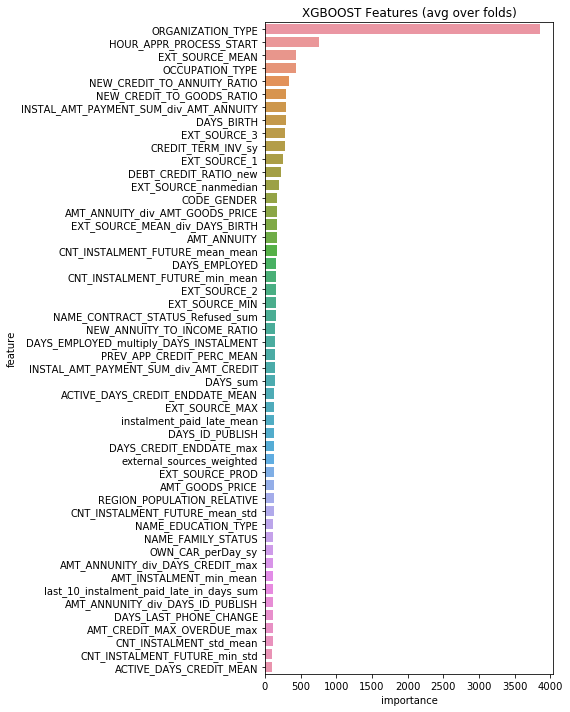

In [52]:
display_importances(feature_importance_df)

In [90]:
def calculate_rank(predictions):
    rank = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return rank

In [91]:
subtmp = pd.DataFrame({'fold%d'%i:sub_preds[:,i] for i in range(sub_preds.shape[1])})
subtmp.head()

,fold0,fold1,fold2,fold3,fold4
0,0.033801,0.037415,0.041009,0.032710,0.034807
1,0.131331,0.136465,0.116508,0.140806,0.138971
2,0.053150,0.045165,0.037186,0.042937,0.046677
3,0.039880,0.038627,0.038301,0.034237,0.034553
4,0.141124,0.138135,0.137591,0.180577,0.132549


In [92]:
pred = []
for i in range(subtmp.shape[1]):
    pred.append(calculate_rank(subtmp['fold%d'%i]))
pred

[array([0.4292748 , 0.84736896, 0.58957842, ..., 0.03417786, 0.33457791,
        0.89131193]),
 array([0.46519643, 0.85508257, 0.53158273, ..., 0.03702944, 0.37449995,
        0.8283106 ]),
 array([0.48298287, 0.81944815, 0.44704072, ..., 0.02104831, 0.39405067,
        0.90579547]),
 array([0.43836291, 0.86691968, 0.53451636, ..., 0.02051492, 0.36379116,
        0.82201251]),
 array([0.44548159, 0.86277567, 0.5509283 , ..., 0.03177762, 0.33201354,
        0.83292645])]

In [95]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': np.mean(pred,axis=0)})
submission.to_csv("lgbm_test711.csv", index=False)

In [96]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.452260
1,100005,0.850319
2,100013,0.530729
3,100028,0.464048
4,100038,0.868491


In [20]:
df_train = AllTrainData
df_test = TestData
num_folds = 10
stratified = True
debug= False

In [40]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros(df_test.shape[0])
roc_score_list = []
bestModel = None
bestRoc = None
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    if n_fold!=0:
        break
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(is_unbalance=False,
                               scale_pos_weight = 2,
                               reg_alpha=0.0,
                               reg_lambda=90,
                               min_split_gain=0.5,
                               colsample_bytree=0.05,
                               subsample_freq=1,
                               subsample=1,
                               min_child_samples=70,
                               num_leaves=34,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               n_estimators=10000,
                               boosting_type='gbdt',
                               application="binary",
                               num_threads = -1
                              )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds = clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1099), test shape: (48744, 1098)
Num of Feature: 1083
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.788275	valid's auc: 0.771996
[400]	train's auc: 0.806533	valid's auc: 0.782915
[600]	train's auc: 0.820113	valid's auc: 0.788594
[800]	train's auc: 0.83118	valid's auc: 0.791878
[1000]	train's auc: 0.840819	valid's auc: 0.793993
[1200]	train's auc: 0.84951	valid's auc: 0.795149
[1400]	train's auc: 0.857187	valid's auc: 0.796227
[1600]	train's auc: 0.864426	valid's auc: 0.796873
[1800]	train's auc: 0.871054	valid's auc: 0.797249
[2000]	train's auc: 0.877101	valid's auc: 0.797502
[2200]	train's auc: 0.882725	valid's auc: 0.797484
Early stopping, best iteration is:
[2135]	train's auc: 0.880945	valid's auc: 0.79756
Fold  1 AUC : 0.797560


In [41]:
sub_preds

array([0.07623123, 0.21191958, 0.07922843, ..., 0.0152783 , 0.04383713,
       0.30151095])

In [44]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': sub_preds})
submission.to_csv("lgbm_test0735.csv", index=False)

In [43]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.076231
1,100005,0.211920
2,100013,0.079228
3,100028,0.075134
4,100038,0.219361


In [51]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros(df_test.shape[0])
roc_score_list = []
bestModel = None
bestRoc = None
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    if n_fold!=0:
        break
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(
            nthread=-1,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=30,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            scale_pos_weight=1
            )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds = clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1099), test shape: (48744, 1098)
Num of Feature: 1090
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.793208	valid's auc: 0.773318
[400]	train's auc: 0.821159	valid's auc: 0.786561
[600]	train's auc: 0.840216	valid's auc: 0.791048
[800]	train's auc: 0.855889	valid's auc: 0.792891
[1000]	train's auc: 0.869291	valid's auc: 0.793552
[1200]	train's auc: 0.880883	valid's auc: 0.793547
Early stopping, best iteration is:
[1103]	train's auc: 0.875408	valid's auc: 0.793812
Fold  1 AUC : 0.793812


In [47]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': sub_preds})
submission.to_csv("lgbm_test0736.csv", index=False)